# Linear Regression with Regularization

First, import the required libraries

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.ion() # Make plots interactive

In [2]:
def dataset_reader(filename):
    """
    Params: Name of the file to load
    Returns: A numpy array of with all entries converted to float datatype
    """
    return np.array(pd.read_csv(filename, header = None),dtype = np.float)

In [12]:
class LinearRegression:
    """
    A Linear Regression Model
    """
    def __init__(self, X, y, learningRate, maxIterations, tolerance, 
                 gd = False, gd_type = "batch", regularization = False, lmbda = 0):
        """
        Initalizer for the class
        
        @Params:
            X, y: Training data 
            learningRate (Float): The learning rate for the gradient descent algorithm
            maxIterations (Int): Max number of epochs
            tolerance (Float): Allowed tolerance for difference in cost function value
            gd (Boolean): Flag to set gradient descent to True/False
            gd_type (String): If set to "batch", uses batch gradient descent, if set to "sgd", 
                              ses the stochastic gradient descent
            regularization (Boolean): Flag to use regularization
            lmbda (Float): Value of Lambda used for the regularization
        
        """
        np.random.RandomState(10)
        self.X = X
        self.y = y
        self.learningRate = learningRate
        self.maxIterations = maxIterations
        self.tolerance = tolerance
        self.gd = gd
        self.gd_type = gd_type
        self.regularization = regularization
        self.lmbda = lmbda
        
    def splitToTrainTest(self):
        """
        Splits the data into train and test sets and returns all four
        """
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=0)
        return X_train, X_test, y_train, y_test 
    
    def add_x0(self, X):
        """
        Adds bias column to the data
        """
        return np.column_stack([np.ones([X.shape[0], 1]) , X])
    
    def normalize(self, X):
        """
        Normalizes the data and returns the data, mean and std
        
        """
        mean = np.mean(X, 0)
        std = np.std(X, 0)
        
        X_norm = (X - mean)/std
        X_norm = self.add_x0(X_norm)
        
        return X_norm, mean, std
    
    def normalizeTestData(self, X, train_mean, train_std):
        """
        Normalizes test data using the training data mean and sd
        
        """
        X_norm = (X - train_mean) / train_std
        X_norm = self.add_x0(X_norm)
        
        return X_norm
    
    
    def rank(self, X, eps = 1e-12):
        """
        Calculates and returns the rank of a matrix
        """
        u, s, vh = np.linalg.svd(X)
        return len([x for x in s if abs(x) > eps])
        
    
    def checkMatrix(self, X):
        """
        Checks if a matrix is full rank or not
        """
        x_rank = self.rank(X)
        
        if x_rank == min(X.shape[0], X.shape[1]):
            print("Matrix is full rank")
            self.fullRank = True
        else:
            print("Matrix is not full rank")
            self.fullRank = False
        
    def checkInvertibility(self, X):
        """
        Checks whether a matrix is invertible
        """
        if X.shape[0] < X.shape[1]:
            self.lowRank = True
            print("data is Low Rank")
        else: 
            self.lowRank = False
            print("data is not Low Rank")

            
    def closedFormSolution(self, X, y):
        """
        Finds a closed form solution for theta (w) using the Normal equation
        """
        if self.regularization:
            w = np.linalg.inv((X.T.dot(X)) + self.lmbda*np.identity(X.shape[1])).dot(X.T).dot(y)
        else:
            w = np.linalg.inv((X.T.dot(X))).dot(X.T).dot(y)
        return w
    
    def gradientDescent(self, X, y):
        """
        Performs optimization using batch gradient descent
        """
        self.error_sequence = []
        
        last = float('inf')
        
        for i in tqdm(range(self.maxIterations)):            
            if self.regularization:
                self.w = self.w - self.learningRate * self.costDerivatives(X, y) - self.lmbda * self.w
            else:
                self.w = self.w - self.learningRate * self.costDerivatives(X, y) 
            
            cur = self.costFunction(X, y)
            
            # Since the tolerance values are the difference in RMSEs, divide the SSE by N and take
            # a square root
            rmse_diff = (last/self.X.shape[0])**(1/2) - (cur/self.X.shape[0])**(1/2)
            last = cur
            
            self.error_sequence.append(cur)
            
            # Plot every 50 epochs
            if i in [k for k in range(1, self.maxIterations + 1, 50)]:
                self.plot()
            
            plt.show()
            if rmse_diff < self.tolerance:
                print("Model Stopped")
                break
                
                
    def predict(self, X):
        """
        Predicts labels for the given input data
        """
        return X.dot(self.w)
        
    def sse(self, X, y): 
        """
        Calculates Sum of Squares error
        """
        y_hat = self.predict(X)
        return ((y_hat - y) ** 2).sum()
        
        
    def costFunction(self, X, y):
        """
        Calculates the cost given X and y
        """
        if self.regularization:
            return (1/2)*(self.sse(X, y) + self.lmbda * (self.w.T.dot(self.w)))
        else:
            return self.sse(X, y) / 2
     
    
    def costDerivatives(self, X, y):
        """
        Returns derivative of the cost function for Batch GD
        
        """
        y_hat = self.predict(X)        
        return (y_hat - y).dot(X)
    
    def costDerivativesSGD(self, X, y):
        """
        Returns derivative of the cost function for Stochastic GD
        """
        y_hat = self.predictSGD(X)
        return (y_hat - y) * X
    
    def predictSGD(self, X):
        """
        Predicts labels given X for Stochastic GD
        
        """
        return np.float64(np.array(X).dot(self.w))
    
    
    def stochasticGradientDescent(self, X, y):
        """
        Performs optimization using Stochastic GD
        """
        self.error_sequence = []

        last = float('inf')

        for j in tqdm(range(self.maxIterations)):
            epoch_cost = 0
            row_num = 
            for i, row in enumerate(X):
                if self.regularization:
                    self.w = self.w - self.learningRate * self.costDerivativesSGD(row, y[i]) - self.lmbda * self.w
                else:
                    self.w = self.w - self.learningRate * self.costDerivativesSGD(row, y[i]) 

                cur = self.costFunction(row, y[i])
                last = cur
                epoch_cost += cur

                
            # Plot every 50 epochs
            if j in [k for k in range(1, self.maxIterations+1, 50)]:
                self.plot()
                
            if j > 1:
                rmse_diff = (self.error_sequence[-1]/X.shape[0])**(1/2) - (epoch_cost/X.shape[0])**(1/2) 
                if rmse_diff < self.tolerance:
                    print("Model Stopped")
                    break
                
            self.error_sequence.append(epoch_cost)

                

    def runModel(self):
        """
        Runs the model using the given configurations
        """
        self.X_train, self.X_test, self.y_train, self.y_test = self.splitToTrainTest()
        
        self.X_train, self.mean, self.std = self.normalize(self.X_train)
        self.X_test = self.normalizeTestData(self.X_test, self.mean, self.std)
        
        self.checkMatrix(self.X_train)
        self.checkInvertibility(self.X_train)
        
        if self.fullRank and not self.lowRank and self.X_train.shape[0] < 50000 and not self.gd: 
            
            print("Solving using closed form solution")
            print("Using L2-Regularization, Lambda: ", self.lmbda) if self.regularization else ""
            self.w = self.closedFormSolution(self.X_train, self.y_train)
        
        else:
            
            self.w = np.ones(self.X_train.shape[1], dtype = np.float64) * 0
            
            if self.gd_type == "batch":
                print("Solving using gradient descent")
                self.gradientDescent(self.X_train, self.y_train)
            elif self.gd_type == "sgd":
                print("Solving using Stochastic Gradient Descent")
                self.stochasticGradientDescent(self.X_train, self.y_train)
                
            print(self.w)
            self.plot('Training Complete')
            
            
    def plot(self, title = "Model Training..."):
        """
        Plots Cost vs Epoch 
        """
        # setting labels
        plt.xlabel("Epochs")
        plt.ylabel("Training Cost")
        plt.title(title)
        
        plt.plot(self.error_sequence)
        plt.pause(0.5)
            
    def evaluate_model(self):
        """
        Evaluates the model on test set
        """
        sse = self.sse(self.X_test, self.y_test)
        rmse = (sse/self.X_test.shape[0])**(1/2)
        
        print("Model RMSE Score on Test Set is: ", rmse)

#### Now that we have defined our model, let us see it's performance on the following three datasets

##### 1. Housing Dataset

In [13]:
# Import the housing dataset
df = pd.read_csv("./datasets/housing.csv")

In [14]:
df.head()

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


##### 1.1 Closed Form Solution

In [15]:
regression = LinearRegression(df.values[:, 0:-1], df.values[:,-1], maxIterations=1000,
                    learningRate=0.0004, tolerance=0.001, gd=False, gd_type = "batch", regularization = True, lmbda = 0.001)

In [16]:
regression.runModel()

Matrix is full rank
data is not Low Rank
Solving using closed form solution
Using L2-Regularization, Lambda:  0.001


Let's look at the model weights

In [17]:
regression.w

array([22.93392937, -0.9075087 ,  1.04794718,  0.38863798,  0.66225127,
       -2.1721009 ,  2.58718049,  0.50642973, -2.59557244,  2.308099  ,
       -1.67312074, -2.33650137,  0.65618524, -3.99469858])

Now let us see the model performance on the test set

In [18]:
regression.evaluate_model()

Model RMSE Score on Test Set is:  4.624024253292391


##### 1.2 Using Batch Gradient Descent

In [19]:
regression = LinearRegression(df.values[:, 0:-1], df.values[:,-1], maxIterations=1000,
                    learningRate=0.0004, tolerance=0.001, gd=True, gd_type = "batch", regularization = True, lmbda = 0.001)

  0%|          | 0/1000 [00:00<?, ?it/s]

Matrix is full rank
data is not Low Rank
Solving using gradient descent


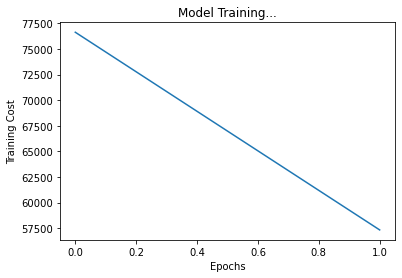

  5%|▍         | 46/1000 [00:00<00:15, 61.72it/s]

Model Stopped
[22.75586608 -0.75373618  0.71010162 -0.09859082  0.7290627  -1.30743266
  2.95426329  0.13001183 -2.10555722  0.9387532  -0.5001978  -2.14793409
  0.66217303 -3.67942838]


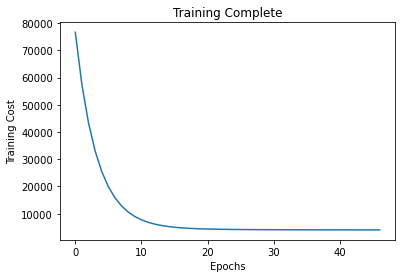

In [20]:
regression.runModel()

The model weights are:

In [21]:
regression.w

array([22.75586608, -0.75373618,  0.71010162, -0.09859082,  0.7290627 ,
       -1.30743266,  2.95426329,  0.13001183, -2.10555722,  0.9387532 ,
       -0.5001978 , -2.14793409,  0.66217303, -3.67942838])

Model performance on test set is:

In [22]:
regression.evaluate_model()

Model RMSE Score on Test Set is:  4.685385417112023


##### 1.3 Using Stochastic Gradient Descent

In [23]:
regression = LinearRegression(df.values[:, 0:-1], df.values[:,-1], maxIterations=1000,
                    learningRate=0.0004, tolerance=0.001, gd=True, gd_type = "sgd", regularization = True, lmbda = 0.00001)

  0%|          | 0/1000 [00:00<?, ?it/s]

Matrix is full rank
data is not Low Rank
Solving using Stochastic Gradient Descent


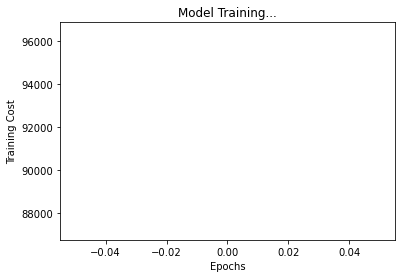

  5%|▍         | 46/1000 [00:00<00:12, 76.26it/s]

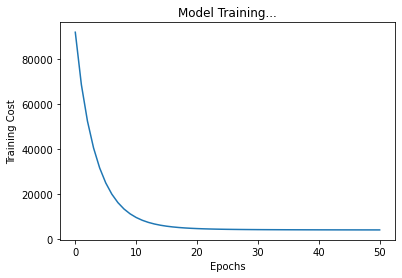

  5%|▌         | 52/1000 [00:01<00:30, 31.36it/s]

Model Stopped
[22.37378365 -0.77969584  0.72124541 -0.10186495  0.74012158 -1.33560843
  2.9298593   0.14234658 -2.0690155   0.93808233 -0.5342062  -2.1449579
  0.65625484 -3.65848467]


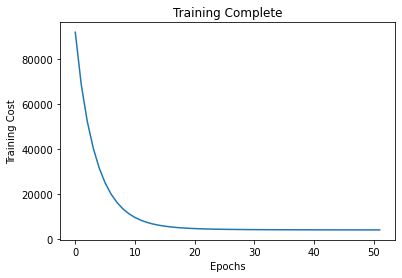

In [24]:
regression.runModel()

In [25]:
# Model Weights
regression.w

array([22.37378365, -0.77969584,  0.72124541, -0.10186495,  0.74012158,
       -1.33560843,  2.9298593 ,  0.14234658, -2.0690155 ,  0.93808233,
       -0.5342062 , -2.1449579 ,  0.65625484, -3.65848467])

Model performance on test set:

In [26]:
regression.evaluate_model()

Model RMSE Score on Test Set is:  4.708848589327138


As we can see both the solutions: Normal as well as Gradient Descent solutions for the Housing dataset have similar results. All of them have approximately the same model weights. Moreover, their RMSE score on the test set is also similar at around 4.6-4.7

#### 2. Yacht Data

In [27]:
# Import the Yacht dataset
df = pd.read_csv("./datasets/yachtData.csv")

In [28]:
df.head()

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82


##### 2.1 Closed Form Solution

In [29]:
regression = LinearRegression(df.values[:, 0:-1], df.values[:,-1], maxIterations=1000,
                    learningRate=0.001, tolerance=0.001, gd=False, gd_type = "batch", regularization = True, lmbda = 0.001)

In [30]:
regression.runModel()

Matrix is full rank
data is not Low Rank
Solving using closed form solution
Using L2-Regularization, Lambda:  0.001


In [31]:
# Let's look at the model weights
regression.w

array([10.74266008,  0.54271106, -0.48655894,  0.53098641, -0.58814081,
       -0.84356367, 12.89445137])

Let's look at model performance on test set

In [32]:
regression.evaluate_model()

Model RMSE Score on Test Set is:  9.05136013191135


##### 2.2 Using Batch Gradient Descent 

In [33]:
regression = LinearRegression(df.values[:, 0:-1], df.values[:,-1], maxIterations=1000,
                    learningRate=0.001, tolerance=0.001, gd=True, gd_type = "batch", regularization = True, lmbda = 0.001)

  0%|          | 0/1000 [00:00<?, ?it/s]

Matrix is full rank
data is not Low Rank
Solving using gradient descent


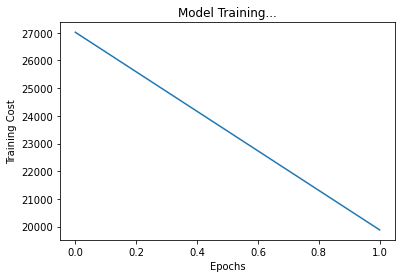

  2%|▏         | 18/1000 [00:00<00:39, 24.98it/s]

Model Stopped
[10.58519363  0.54950453 -0.63620046 -0.12611927 -0.05585083 -0.21229842
 12.70094562]


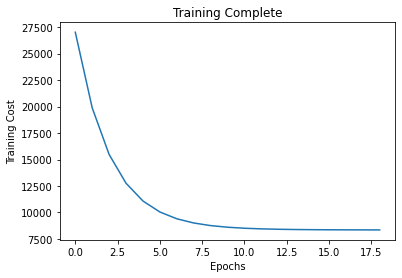

In [34]:
regression.runModel()

In [35]:
# Model Weights
regression.w

array([10.58519363,  0.54950453, -0.63620046, -0.12611927, -0.05585083,
       -0.21229842, 12.70094562])

Test set performance:

In [36]:
regression.evaluate_model()

Model RMSE Score on Test Set is:  8.996798431562576


##### 2.3 Using Stochastic Gradient Descent

In [37]:
regression = LinearRegression(df.values[:, 0:-1], df.values[:,-1], maxIterations=1000,
                    learningRate=0.001, tolerance=0.001, gd=True, gd_type = "sgd", regularization = True, lmbda = 0.0001)

  0%|          | 0/1000 [00:00<?, ?it/s]

Matrix is full rank
data is not Low Rank
Solving using Stochastic Gradient Descent


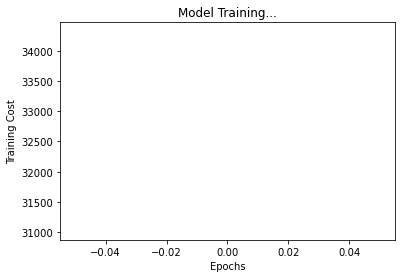

  3%|▎         | 26/1000 [00:00<00:31, 30.75it/s]

Model Stopped
[ 9.7573093   0.56245226 -0.61110346 -0.15533582 -0.12113649 -0.19827041
 11.72325767]


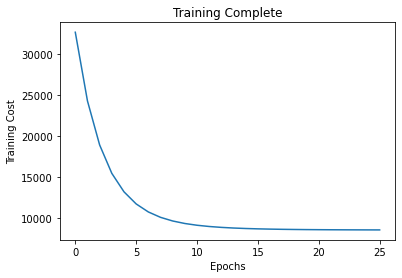

In [38]:
regression.runModel()

In [39]:
# Model weights
regression.w

array([ 9.7573093 ,  0.56245226, -0.61110346, -0.15533582, -0.12113649,
       -0.19827041, 11.72325767])

Let's see test set performance:

In [40]:
regression.evaluate_model()

Model RMSE Score on Test Set is:  8.808564887959838


We can see that for the Yacht dataset, all three models (i.e, Closed Form, BGD and SGD) have similar weights and test set performance. The gradient descent versions perform slightly better on the test set RMSE score (8.8 vs 9.05). 

#### 3. Concrete Data

In [41]:
# Import the Concrete dataset
df = pd.read_csv("./datasets/concreteData.csv")

In [42]:
df.head()

,540,0,0.1,162,2.5,1040,676,28,79.99
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03


#### 3.1 Closed Form Solution

In [43]:
regression = LinearRegression(df.values[:, 0:-1], df.values[:,-1], maxIterations=1000,
                    learningRate=0.0007, tolerance=0.0001, gd=False, gd_type = "batch", regularization = True, lmbda = 0.001)

In [44]:
regression.runModel()

Matrix is full rank
data is not Low Rank
Solving using closed form solution
Using L2-Regularization, Lambda:  0.001


In [45]:
# Model Weights
regression.w

array([35.55864506, 13.07034278,  9.29585262,  6.07729726, -2.38816303,
        2.13444327,  1.74763946,  1.75727736,  7.36634234])

Taking a look at the model's test set performance:

In [46]:
regression.evaluate_model()

Model RMSE Score on Test Set is:  11.10633831300983


##### 3.2 Using Batch Gradient Descent

In [47]:
regression = LinearRegression(df.values[:, 0:-1], df.values[:,-1], maxIterations=1000,
                    learningRate=0.0007, tolerance=0.0001, gd=True, gd_type = "batch", regularization = True, lmbda = 0.001)

  0%|          | 0/1000 [00:00<?, ?it/s]

Matrix is full rank
data is not Low Rank
Solving using gradient descent


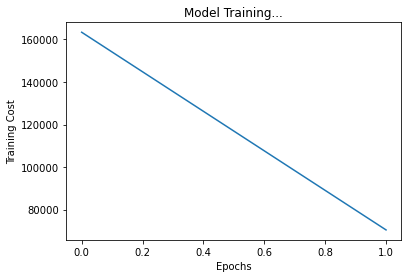

  0%|          | 2/1000 [00:00<05:56,  2.80it/s]

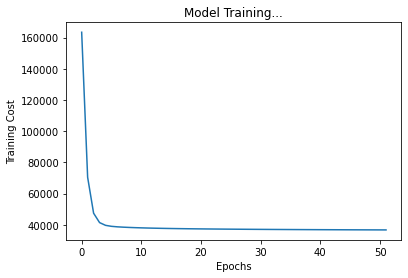

  5%|▌         | 52/1000 [00:01<00:23, 41.08it/s]

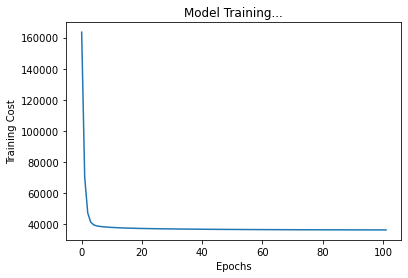

 13%|█▎        | 127/1000 [00:02<00:15, 57.42it/s]

Model Stopped
[35.48828119 12.06965872  8.28748438  5.19789336 -3.1701114   2.06823916
  1.00155658  0.81571259  7.31777493]


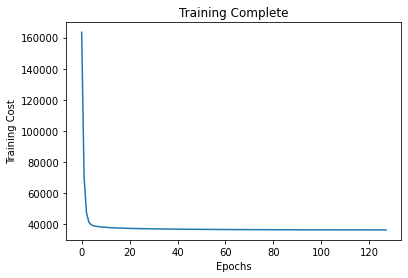

In [48]:
regression.runModel()

In [49]:
# Model Weights
regression.w

array([35.48828119, 12.06965872,  8.28748438,  5.19789336, -3.1701114 ,
        2.06823916,  1.00155658,  0.81571259,  7.31777493])

Looking at model test set performance:

In [50]:
regression.evaluate_model()

Model RMSE Score on Test Set is:  11.098327622955809


##### 3.3 Using Stochastic Gradient Descent

In [51]:
regression = LinearRegression(df.values[:, 0:-1], df.values[:,-1], maxIterations=1000,
                    learningRate=0.0007, tolerance=0.0001, gd=True, gd_type = "sgd", regularization = True, lmbda = 0.000001)

  0%|          | 0/1000 [00:00<?, ?it/s]

Matrix is full rank
data is not Low Rank
Solving using Stochastic Gradient Descent


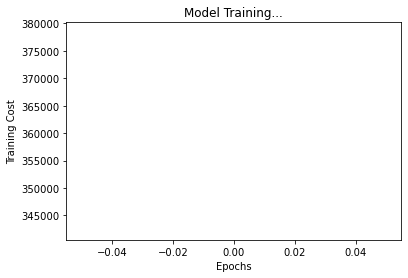

  4%|▍         | 40/1000 [00:01<00:15, 62.51it/s]

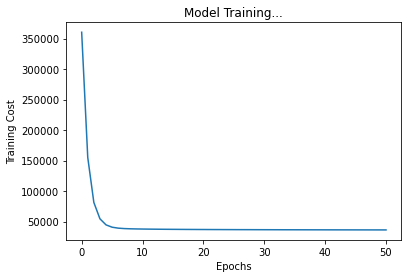

  9%|▉         | 90/1000 [00:02<00:13, 66.97it/s]

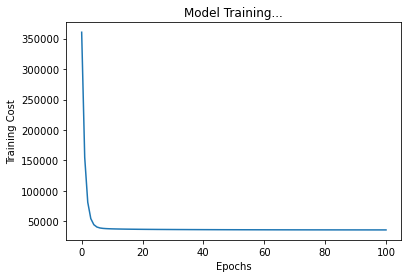

 13%|█▎        | 133/1000 [00:03<00:20, 42.05it/s]


Model Stopped
[35.53357579 12.10758249  8.38636479  5.3444203  -3.07377149  2.10366895
  1.0084625   0.98811502  7.17936603]


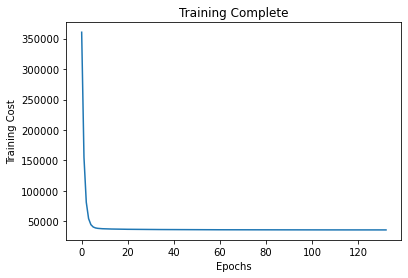

In [52]:
regression.runModel()

In [53]:
# Model Weights
regression.w

array([35.53357579, 12.10758249,  8.38636479,  5.3444203 , -3.07377149,
        2.10366895,  1.0084625 ,  0.98811502,  7.17936603])

Let's look at model's test set performance:

In [54]:
regression.evaluate_model()

Model RMSE Score on Test Set is:  11.045771867321234


All the models have similar performance on the Concrete Dataset, with the test RMSE being around 11.04